In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shared_functions as sf
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [2]:
# Plot Functions
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [5]:
# Basic EDA
train_data = pd.read_csv('train.csv')

# Labels
train_labels = train_data.loc[:,'SalePrice']

# Dummify for now
original_data = train_data.copy()
train_data = pd.get_dummies(train_data)

# Data
split = 200
train_data = train_data.drop('SalePrice', axis = 1)

# Split train data and dev Data
dev_data = train_data[:split]
train_data = train_data[split:]
dev_labels = train_labels[:split]
train_labels = train_labels[split:]

# Test data
test_data = pd.read_csv('test.csv')

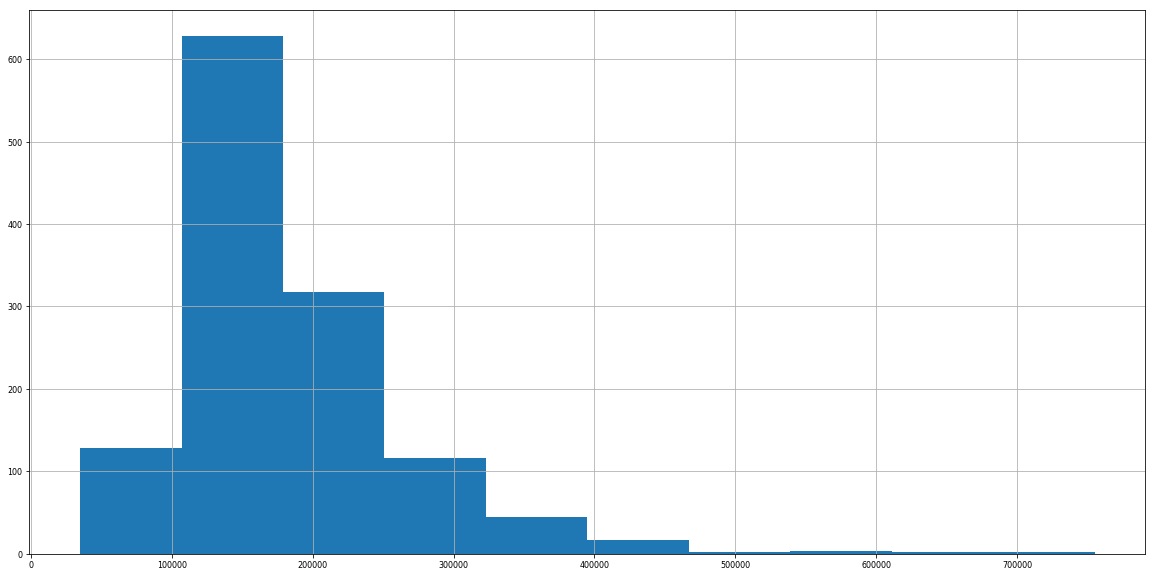

In [6]:
plt.figure(figsize=(20,10))
train_labels.hist()

In [7]:
# Basic Descriptions on all variables

# Numeric 
train_data.describe(include=[np.number]).transpose()
pd.DataFrame(original_data.columns.values).to_csv('colnames.csv')

Lots of continuous variables and categorical ones - and not a lot of data (1460). Will probably not be a linear combination of features - probably some kind of tree-based model?

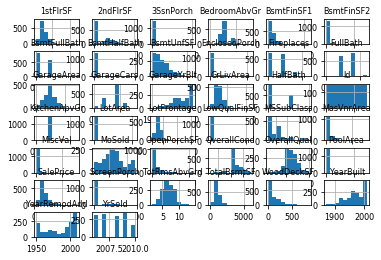

In [8]:
trainhist = original_data.hist()
plt.savefig('./numeric_EDA.pdf')

In [9]:
# Categorical
original_data.select_dtypes(include='object').apply(lambda x: x.value_counts()).T.stack()


MSZoning       C (all)      10.0
               FV           65.0
               RH           16.0
               RL         1151.0
               RM          218.0
Street         Grvl          6.0
               Pave       1454.0
Alley          Grvl         50.0
               Pave         41.0
LotShape       IR1         484.0
               IR2          41.0
               IR3          10.0
               Reg         925.0
LandContour    Bnk          63.0
               HLS          50.0
               Low          36.0
               Lvl        1311.0
Utilities      AllPub     1459.0
               NoSeWa        1.0
LotConfig      Corner      263.0
               CulDSac      94.0
               FR2          47.0
               FR3           4.0
               Inside     1052.0
LandSlope      Gtl        1382.0
               Mod          65.0
               Sev          13.0
Neighborhood   Blmngtn      17.0
               Blueste       2.0
               BrDale       16.0
          

Generally most of the value appear to be OK - not many missing values, but the categories can be fairly unbalanced in some cases (e.g. most "Sale Condition" is normal). 

### Missing Values
Missing values look ok - some easy candidates to remove from our feature set. 

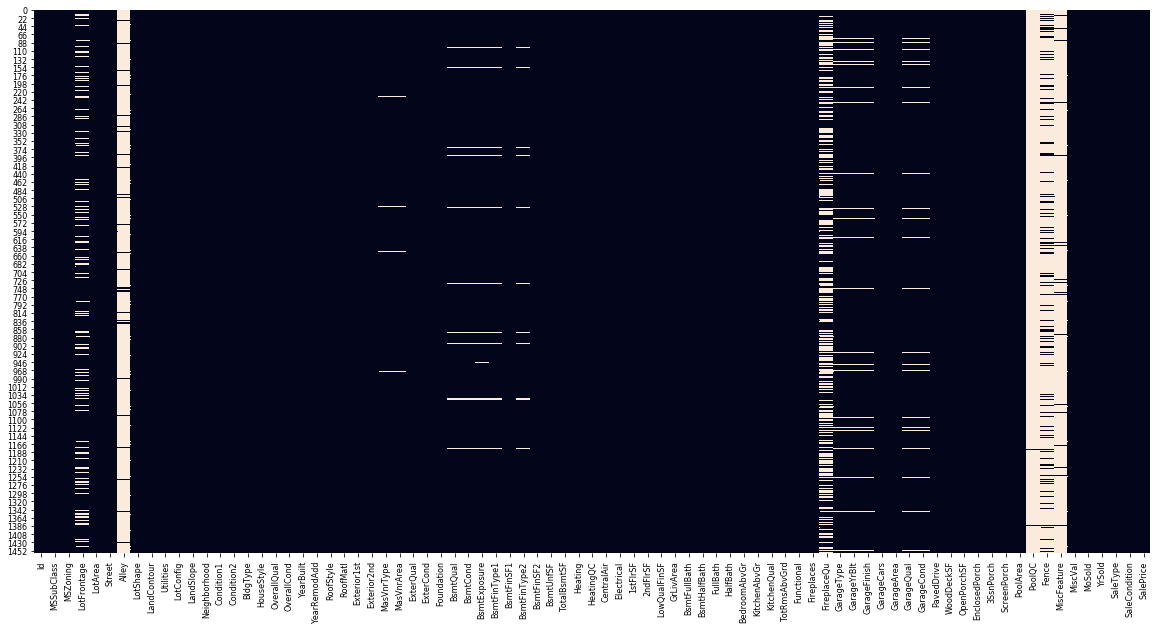

In [10]:
# Missing Values
plt.figure(figsize=(20,10))
sns.heatmap(original_data.isnull(), cbar=False)
plt.savefig('./missing_EDA.pdf')

In [15]:
# Drop these variables that have a lot missing
print(original_data['Alley'].value_counts(dropna = False))
print(original_data['PoolQC'].value_counts(dropna = False))
print(original_data['Fence'].value_counts(dropna = False))
print(original_data['MiscFeature'].value_counts(dropna = False))

newdata = original_data.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])



NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
NaN    1453
Gd        3
Fa        2
Ex        2
Name: PoolQC, dtype: int64
NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64
NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64


### Remove (categorical) features that have a major class imbalance


In [63]:
# Compile list of vars
list_of_vars = list(original_data.select_dtypes('object').columns)
list_of_vars.append('MSSubClass')

for var in list_of_vars:
    print("\n\n***********", var)
    freq_table = pd.DataFrame(original_data[var].value_counts(dropna=False))
    saleprice = pd.DataFrame(original_data.groupby(var)['SalePrice'].mean())
    print(freq_table)
    print(saleprice.round(0))



*********** MSZoning
         MSZoning
RL           1151
RM            218
FV             65
RH             16
C (all)        10
          SalePrice
MSZoning           
C (all)     74528.0
FV         214014.0
RH         131558.0
RL         191005.0
RM         126317.0


*********** Street
      Street
Pave    1454
Grvl       6
        SalePrice
Street           
Grvl     130190.0
Pave     181131.0


*********** Alley
      Alley
NaN    1369
Grvl     50
Pave     41
       SalePrice
Alley           
Grvl    122219.0
Pave    168001.0


*********** LotShape
     LotShape
Reg       925
IR1       484
IR2        41
IR3        10
          SalePrice
LotShape           
IR1        206102.0
IR2        239833.0
IR3        216036.0
Reg        164755.0


*********** LandContour
     LandContour
Lvl         1311
Bnk           63
HLS           50
Low           36
             SalePrice
LandContour           
Bnk           143104.0
HLS           231534.0
Low           203661.0
Lvl           180184.0

TA            139963.0


*********** Functional
      Functional
Typ         1360
Min2          34
Min1          31
Mod           15
Maj1          14
Maj2           5
Sev            1
            SalePrice
Functional           
Maj1         153948.0
Maj2          85800.0
Min1         146385.0
Min2         144241.0
Mod          168393.0
Sev          129000.0
Typ          183429.0


*********** FireplaceQu
     FireplaceQu
NaN          690
Gd           380
TA           313
Fa            33
Ex            24
Po            20
             SalePrice
FireplaceQu           
Ex            337712.0
Fa            167298.0
Gd            226351.0
Po            129764.0
TA            205723.0


*********** GarageType
         GarageType
Attchd          870
Detchd          387
BuiltIn          88
NaN              81
Basment          19
CarPort           9
2Types            6
            SalePrice
GarageType           
2Types       151283.0
Attchd       202893.0
Basment      160571.0
BuiltIn      2547

### Impute means for categorical features

### Remove Features that are highly correlated

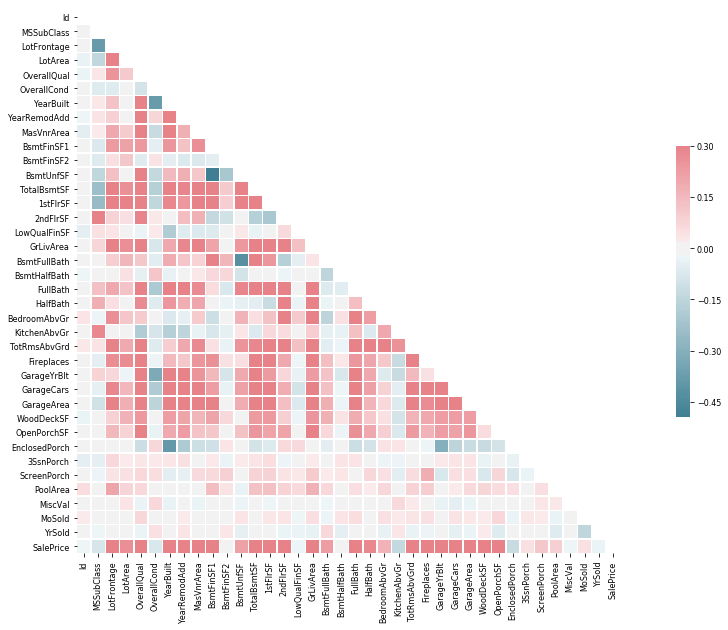

In [16]:
# Correlation matrix
plt.figure(figsize=(20,10))
corr = original_data.select_dtypes(exclude='object').corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Use an algorithmic Feature Selection method

In [17]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.impute import SimpleImputer

# Binarize all categorical
original_data_dummy = pd.get_dummies(original_data.drop(['SalePrice'], axis = 1))

# Impute all numeric
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
original_data_dummy_array = imp.fit_transform(original_data_dummy)

rf = RandomForestRegressor()
rf.fit(original_data_dummy_array, original_data['SalePrice'])
rf.feature_importances_

feature_importances = pd.DataFrame(rf.feature_importances_.round(4),
                                   index = original_data_dummy.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances
# Plot
#feature_importances.nlargest(30,'importance').plot(kind='barh')

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
OverallQual,0.5861
GrLivArea,0.1007
2ndFlrSF,0.0499
TotalBsmtSF,0.0339
BsmtFinSF1,0.0234
LotArea,0.0223
1stFlrSF,0.0218
GarageCars,0.0215
TotRmsAbvGrd,0.0110
GarageArea,0.0109


### Keep variables that are highly correlated with the predictor (continuous)

In [18]:
corr_with_salep = original_data.select_dtypes(exclude='object').drop("SalePrice", axis=1).apply(lambda x: x.corr(original_data.SalePrice))
np.abs(corr_with_salep).sort_values(ascending=False)

# For now I just keep variables that have 0.3 and above correlation

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
dtype: float64

### Identify variables that are highly correlated with the predictor (categorical - use oneway Anova)

In [19]:
# https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/

### Run a Simple Linear Model

In [20]:
# New Data
newtrain_data = pd.get_dummies(newdata)

# Data
split = 200
newtrain_data = newtrain_data.drop('SalePrice', axis = 1)

# Split train data and dev Data
dev_newdata = newtrain_data[:split]
train_newdata = newtrain_data[split:]



In [25]:
linearmodel = LinearRegression()
linearmodel.fit(train_newdata.fillna(0), train_labels)
dev_pred = linearmodel.predict(dev_newdata.fillna(0))

# Mean Abs % Error
print(np.mean(np.abs(dev_pred-dev_labels)/dev_labels))

# RMSLE
sf.rmsle(dev_labels, dev_pred)

0.11094189261102713


0.20748008347583663

In [26]:
linearmodel.fit(train_data.fillna(0), train_labels)
dev_pred = linearmodel.predict(dev_data.fillna(0))

# Mean Abs % Error
print(np.mean(np.abs(dev_pred-dev_labels)/dev_labels))

# RMSLE
sf.rmsle(dev_labels, dev_pred)

0.1123379574911979


0.19186040746590072

### Run a Random Forest 

In [27]:
# Binarize all categorical
original_data_dummy = pd.get_dummies(original_data.drop(['SalePrice'], axis = 1))

# Impute all numeric
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
original_data_dummy_array = imp.fit_transform(original_data_dummy)

# Split train data and dev Data
split = 200
dev_rfdata = original_data_dummy_array[:split]
train_rfdata = original_data_dummy_array[split:]

# Run RF
rf = RandomForestRegressor()
rf.fit(train_rfdata, train_labels)
dev_pred = rf.predict(dev_rfdata)

# Mean Abs % Error
print(np.mean(np.abs(dev_pred-dev_labels)/dev_labels))

# RMSLE
sf.rmsle(dev_labels, dev_pred)

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.11593184892148199


0.15353691540523778